### The Linear Regression File 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LinearRegression

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [ ]:
# import preprocess
import test2233

In [ ]:
test_data = np.random.randint(0,30,size=(11,13))
X, y = test2233.test666(test_data)
print(X)
print('--'*25)
print(y)

[[ 4.  7.  5. 12. 19. 10.  6. 16. 10.  6. 11. 16.]
 [ 8.  0. 13.  5.  5. 29.  3.  6.  5.  5.  9. 25.]
 [16. 27. 12.  5.  1. 20. 18. 27. 23.  5.  3. 10.]
 [27. 15. 21. 25.  9. 26. 12.  0. 23.  4. 23.  6.]
 [ 4.  4. 28. 18. 29. 22.  3. 18.  3. 18. 22.  8.]
 [25. 18. 25. 16. 28.  6. 11. 10. 25. 13. 15. 11.]
 [11. 19. 26. 27.  2. 21. 12.  8. 22. 19. 10. 17.]
 [ 3. 13. 14. 14. 27. 17.  7. 26. 20. 24. 16.  3.]
 [15. 19. 28. 12. 26. 15. 15. 25. 15.  4.  7.  5.]
 [21.  7. 10.  4.  5. 21.  8. 13. 29.  0.  8. 12.]
 [ 8. 25. 10.  5. 12. 14. 14. 18. 15.  5. 12. 11.]]
--------------------------------------------------
[ 5. 15. 28.  6.  5.  8.  2.  4.  0.  8.  3.]


(11, 1)
(11,)


TypeError: Axes.text() missing 1 required positional argument: 's'

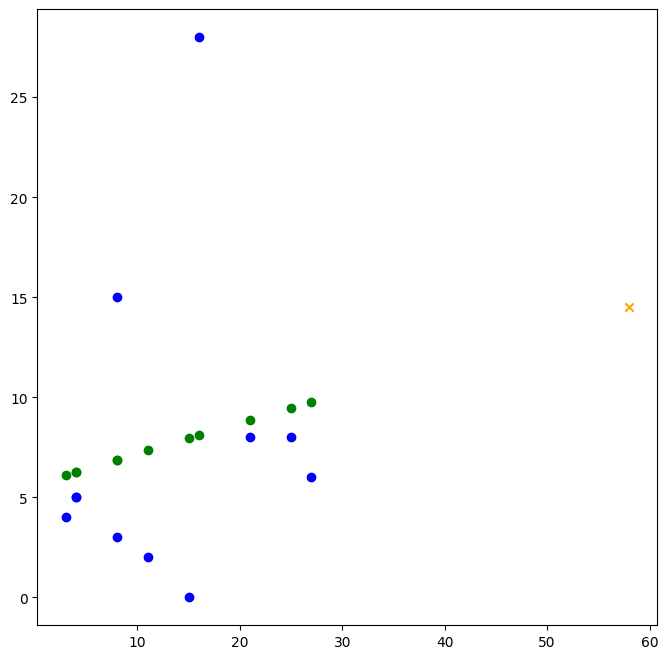

In [ ]:
X0 = X[:, [0]]
new_x = 58
lin_reg_model = LinearRegression()
lin_reg_model.fit(X0, y)
y_pred = lin_reg_model.predict(X0)
y_pred_new_x = lin_reg_model.predict(np.array([[new_x]]))[0]

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

print(X0.shape)
print(y.shape)

ax.scatter(X0, y, color='blue', alpha=1, label='data')
ax.scatter(X0,y_pred, color='green')
ax.scatter(new_x, y_pred_new_x, color='orange', marker='x', label=f'pred at {new_x}')
ax.text(new_x, y_pred_new_x, f'{y_pred_new_x:2f}', color='orange')

# for x_value, y_value in zip(X0[:, 0], y_pred):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(2,1), fontsize=8, color='green')
    
# for x_value, y_value in zip(X0[:, 0], y):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(1,1), fontsize=8, color='blue')

ax.plot(X0, y_pred, color='black', label='LOBF')

# for i in range(len(X0)):
#     ax.arrow(X0[i, 0],y_pred[i],0,y[i]-y_pred[i], length_includes_head=True, color='red')

# ax.set_xlabel('Days for this Feature')
# ax.set_ylabel('Value of the Target')
ax.legend()
ax.grid()
